<a href="https://colab.research.google.com/github/ZeshanRasul/RoBERTa_VADER_NLP_Evaluation/blob/main/VADER_RoBERTa_Sentiment_Analysis_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing VADER and RoBERTa methods for Sentiment Analysis of Amazon Reviews

This project will explore sentiment analysis techniques and performance using a traditional NLP algorithm, VADER found in NLTK and then compare results with the modern RoBERTa model.

**VADER** (Valence Aware Dictionary and sEntiment Reasoner) is a classical **bag of words** approach to sentiment analysis.

**RoBERTa** on the other hand is a more up-to-date **transformer** architecture which is available as a pretrained model from HuggingFace.

## Stage 0: Load Data and Perform Exploratory Data Analysis



In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

The dataset for this project is the Amazon Fine Food Reviews dataset which can be found on Kaggle here: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

In [2]:
!unzip Reviews.csv.zip

Archive:  Reviews.csv.zip
  inflating: Reviews.csv             


In [3]:
df = pd.read_csv('Reviews.csv')

### Exploratory Data Analysis

Once we've read in our dataset with Pandas, we can look at the first five examples.

Of particular note for our sentiment analysis is the Score column with a rating from 1 to 5 and the Text heading which contains the review text which our models will analyse and use to predict the sentiment.

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Below is an example of the text of a review, looking at the first entry in the dataset.

In [5]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

Next we can look at the shape of our dataset to understand how many examples we have.

In [6]:
df.shape

(568454, 10)

We have well over 500,000 examples each with a 10 columns. For the sake of training time, we will downsample this training set to 1000 examples. We may want to use the original dataset with all 500,000 examples later depending on the performance of our models.

In [7]:
downsampled_df = df.head(1000)

Let's get a better understanding of our data by plotting the distribution of scores. We can use matplotlib to produce a histogram showing the number of examples for each score. This will help us understand the balance of our data and guide our model development process.

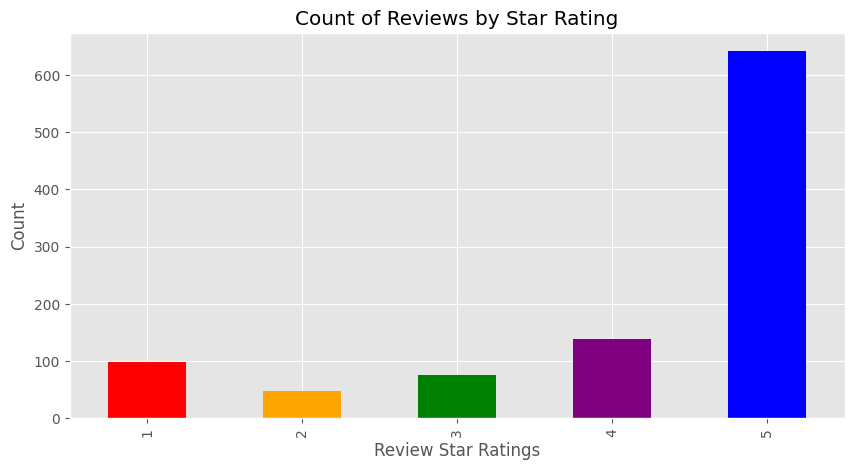

In [8]:
ax = downsampled_df['Score'].value_counts().sort_index()\
    .plot(kind='bar', title='Count of Reviews by Star Rating', figsize=(10, 5),
          color=['red', 'orange', 'green', 'purple', 'blue'])

ax.set_xlabel('Review Star Ratings')
ax.set_ylabel('Count')

plt.show()

We can see our dataset is highly skewed towards 5 Star ratings. This suggests most of our text examples will have a positive sentiment. This imbalance may affect the performance of our models. During training they will be exposed to positive sentiment examples much more than negative sentiment examples. Thus, they may err on the side of positivity and make predictions of positive sentiments more often.

## Step 1: VADER Sentiment Scoring



Our first approach to sentiment analysis will be using NLTK's `SentimentIntensityAnalyzer`. This provides us with a scoring of each body of text in negative, neutral and positive categories.

This technique uses a **bag of words** method:


1.  Stop words (words with very little impact on the overall sentiment) are removed
2.  Each word is scored with negative, neutral and positive scores
3.  The scores for each word in the text are combined to produce a final sentiment score






In [9]:
import nltk

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

We can now use our `sia` sentiment analyzer to calculate scores based on a given body of text.

Below we test out some example strings demonstrating positive, neutral and negative examples.

In [11]:
sia.polarity_scores('Sentiment analysis is so fun! I love it!')

{'neg': 0.0, 'neu': 0.35, 'pos': 0.65, 'compound': 0.8835}

In [12]:
sia.polarity_scores('I don\'t mind sentiment analysis, it\'s okay I guess.')

{'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'compound': 0.2263}

In [13]:
sia.polarity_scores('I really dislike sentiment analysis! It\'s the worst!')

{'neg': 0.602, 'neu': 0.398, 'pos': 0.0, 'compound': -0.8214}

Note the scores for 'neg', 'neu' and 'pos'. These are scores between 0 and 1 that rate the intensity of each sentiment in the given text.

The 'compound' score is an aggregate of the three sentiment scores and ranges from -1 to 1. -1 signifies as a highly negative sentiment, 0 corresponds to a neutral result and 1 suggests the text is most likely to be positive.

### Calculate Polarity Score for All Examples

In [14]:
polarity_scores = {}

for i, row in tqdm(downsampled_df.iterrows(), total=len(downsampled_df)):
  text = row['Text']
  id = row['Id']

  polarity_scores[id] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

We can now take our dictionary of polarity scores with the example ID as the key and polarity score for the example as the value and store it in a Pandas dataframe.

In [15]:
vaders = pd.DataFrame(polarity_scores).T
vaders

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468
...,...,...,...,...
996,0.026,0.721,0.253,0.9788
997,0.000,0.786,0.214,0.9309
998,0.000,0.673,0.327,0.9634
999,0.063,0.874,0.062,-0.0129


Now that we have our VADER sentiment scores as a Pandas dataframe, we can merge this to our downsampled original dataframe to have the scores and full training example metadata in the same dataframe.

In [16]:
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(downsampled_df, how='left')
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plot Vader Results

Now lets use Seaborn to create a barplot of the VADER compound score against the Amazon star ratings which range from 1 to 5.

We would expect the compound score to increase with the star ratings so this plot is a good opportunity to sense check our VADER results.

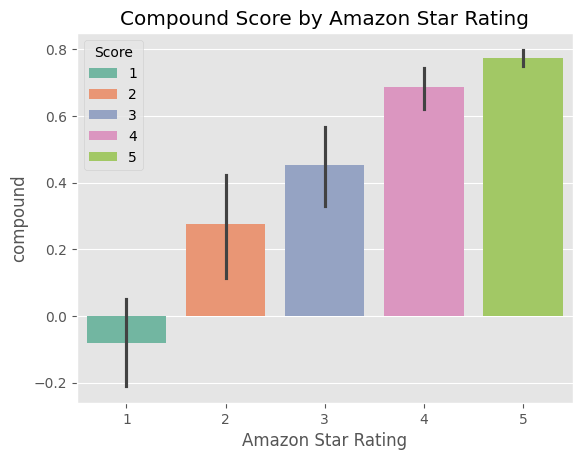

In [17]:
ax = sns.barplot(data=vaders, x='Score', y='compound', hue='Score', palette='Set2')
ax.set_xlabel('Amazon Star Rating')
ax.set_title('Compound Score by Amazon Star Rating')
plt.show()

As expected, the compound score increases as the Amazon star rating increases. This makes sense as we would expect a more positive sentiment for reviews with high star ratings and a more negative sentiment for reviews that award a low star rating.

Let's break the visualisation down further by looking at the positive, neutral and negative scores for each star rating.

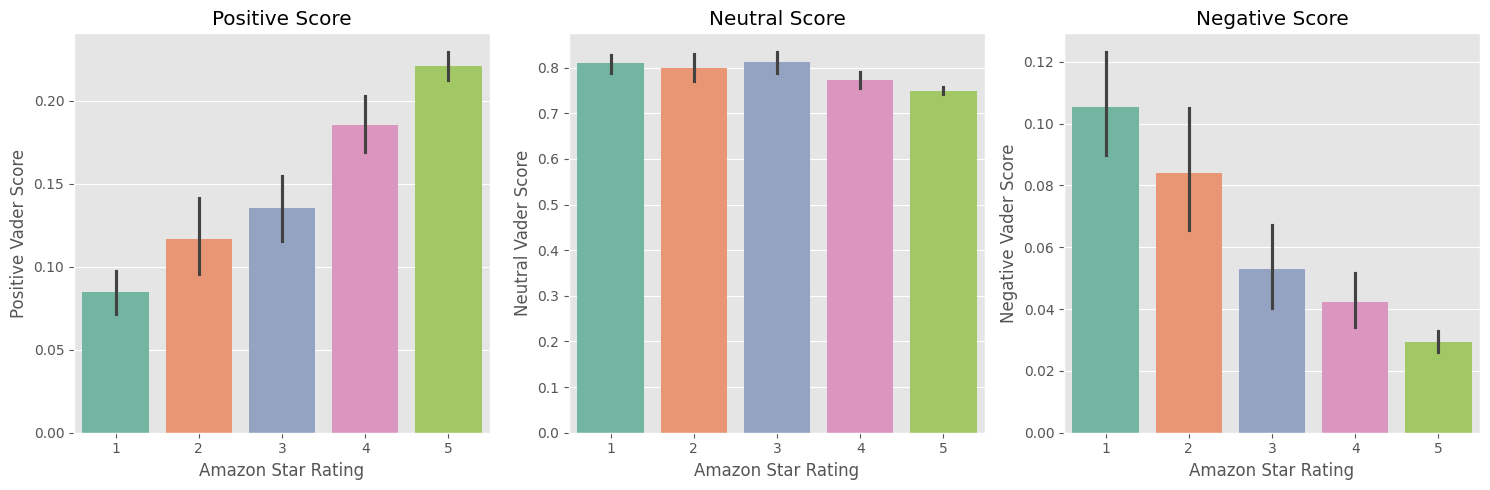

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0], hue='Score', palette='Set2', legend=False)
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1], hue='Score', palette='Set2', legend=False)
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2], hue='Score', palette='Set2', legend=False)

axs[0].set_xlabel('Amazon Star Rating')
axs[1].set_xlabel('Amazon Star Rating')
axs[2].set_xlabel('Amazon Star Rating')

axs[0].set_ylabel('Positive Vader Score')
axs[1].set_ylabel('Neutral Vader Score')
axs[2].set_ylabel('Negative Vader Score')


axs[0].set_title('Positive Score')
axs[1].set_title('Neutral Score')
axs[2].set_title('Negative Score')

plt.tight_layout()
plt.show()

This breakdown of the postive, neutral and negative VADER scores for each star rating supports our expectations further.

The positive sentiment found in the reviews increases as the star rating increases. Customers are more likely to show positive sentiments towards products they review well.

Looking at the negative VADER scores, we can see that lower rating reviews have a higher negative sentiment score. Again, customers who rate a product highly will show little negative sentiment in their review, whereas reviews for a poorly rated product will usually show a negative sentiment in their text.

Neutral scores are fairly even throughout all ratings. This suggests neutral VADER scores that are balanced across star ratings and that our analysis should place greater importance on the positive and negative scores.

Overall, our results show that VADER is still a useful model. It successfully shows a sensible trend in the sentiment of the Amazon reviews and the results show a trend that we would expect to see using our own knowledge of human behaviours and language.

## Step 2: RoBERTa Pretrained Model

Whereas the VADER model looked at each word individually and produced a sentiment score that was the combination of all individual word scores, the RoBERTa model considers the wider context of the text. Specifically, RoBERTa takes into account the relationship between words used in a body of text and provides a score that analyses sentiment using these relationships to provide more information on the meaning of a word as part of a larger section of text.

The model used by RoBERTa is a transformer based, deep learning model. It is trained on a large corpus of textual data providing it with much more knowledge of word meanings, their usages and how they relate when used in human language. This results in a model that haqs a deep understanding of context and its intricacies in the realm of human expression.

### Downloading Pretrained RoBERTa Model and Weights

In [19]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

The following code download a pretrained RoBERTa model from HuggingFace. The model  has been trained to perform sentiment analysis on a Twitter dataset, which is a very similar use case to our requirements. Thus, we will use this model for transfer learning and do not need to retrain it. This means we can use pre-existing weights and model architecture without needing to make any modifications. We will also use the tokenizer from the pretrained model in order to create individual tokens from our body of text for each review.

In [20]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

### Comparing VADER and RoBERTa on a Single Example

We can start by looking at how RoBERTa can be used to perform sentiment analysis on a single example and compare it to the VADER scoring on that same example.

In [21]:
example = downsampled_df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


Looking at the example, it clear demonstrates a negative sentiment towards the product. Let's see what our models think about this example.

To use RoBERTa, we first tokenize the text and specify we want to return tensors in a PyTorch format. These tensors consist of the embeddings for each token. In orther words, the tokens are represented in a numerical form that is interpretable by the model. This is our text encoded for use by the model.

We then pass this encoded text to the model and convert the output to a NumPy array. Finally we apply the Softmax function to each value in the model result to give us a resulting score for positive, neutral and negative sentiment that is between 0 and 1.

In [22]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

scores_dict = {
    'RoBERTa_neg' : scores[0],
    'RoBERTa_neu' : scores[1],
    'RoBERTa_pos' : scores[2]
}

print(scores_dict)

{'RoBERTa_neg': 0.97635514, 'RoBERTa_neu': 0.020687465, 'RoBERTa_pos': 0.0029573706}


This looks very promising, RoBERTa has confidently predicted that this example text is a negative review with a negative score very close to 1. The neutral and positive scores are very close to 0 suggesting the model think it is extremely unlikely that there are any neutral or positive sentiments in this review.

Now we can use VADER on this example to see how it compares.

In [23]:
vader_example_scores = sia.polarity_scores(example)
print(vader_example_scores)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}


VADER doesn't do as well as RoBERTa here. There is a relatively low compound score which suggests the overall sentiment is negative, however the actually negative score isn't very high. The highest score is in fact neutral while the positive score is 0.0.

This shows that VADER does understand there is not any positive sentiment in the message, however it is not as confident as RoBERTa in predicting that the sentiment of the review text is negative. RoBERTa on the other hand was very confident the review text sentiment was negative and this was reflected in the size of it's scores.

The above comparison shows RoBERTa promises to provide some very intelligent results and will do a better job of sentiment analysis than VADER. Let's now use it for our entire dataset.

### Using RoBERTa on Full Dataset

To use RoBERTa on our entire (downsampled) dataset, we can start by creating a function that performs the analysis of a single example using the code a few cells above which returns a dictionary of the sentiment scores for that one example. Then we can loop over the dataset as we did with VADER and compute the RoBERTa sentiment scores for every example.

In [24]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)

  scores_dict = {
      'RoBERTa_neg' : scores[0],
      'RoBERTa_neu' : scores[1],
      'RoBERTa_pos' : scores[2]
  }

  return scores_dict

In [25]:
sentiment_scores = {}

for i, row in tqdm(downsampled_df.iterrows(), total=len(downsampled_df)):
  try:
    text = row['Text']
    id = row['Id']

    vader_result = sia.polarity_scores(text)

    vader_result_rename = {}
    for key, value in vader_result.items():
      vader_result_rename[f"VADER_{key}"] = value

    roberta_result = polarity_scores_roberta(text)

    both_results = {**vader_result_rename, **roberta_result}

    sentiment_scores[id] = both_results

  except RuntimeError:
    print(f"Failed to run for Id: {id}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Failed to run for Id: 83
Failed to run for Id: 187
Failed to run for Id: 529
Failed to run for Id: 540
Failed to run for Id: 746
Failed to run for Id: 863


Now that we have a dictionary of VADER and RoBERTa scores, we can follow the same steps as earlier to create a Pandas dataframe of the sentiment scores.

In [26]:
results_df = pd.DataFrame(sentiment_scores).T
results_df = results_df.reset_index().rename(columns={'index' : 'Id'})
results_df = results_df.merge(downsampled_df, how='left')
results_df.head()

,Id,VADER_neg,VADER_neu,VADER_pos,VADER_compound,RoBERTa_neg,RoBERTa_neu,RoBERTa_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Step 3: Compare Model Performance

We can compare the RoBERTa and VADER results using a Seaborn pairplot. Useful insights can be gleaned from a pairplot by looking at the confidence of both models in their prediction. We can also see if there are any correlations between the predictions of the two models.

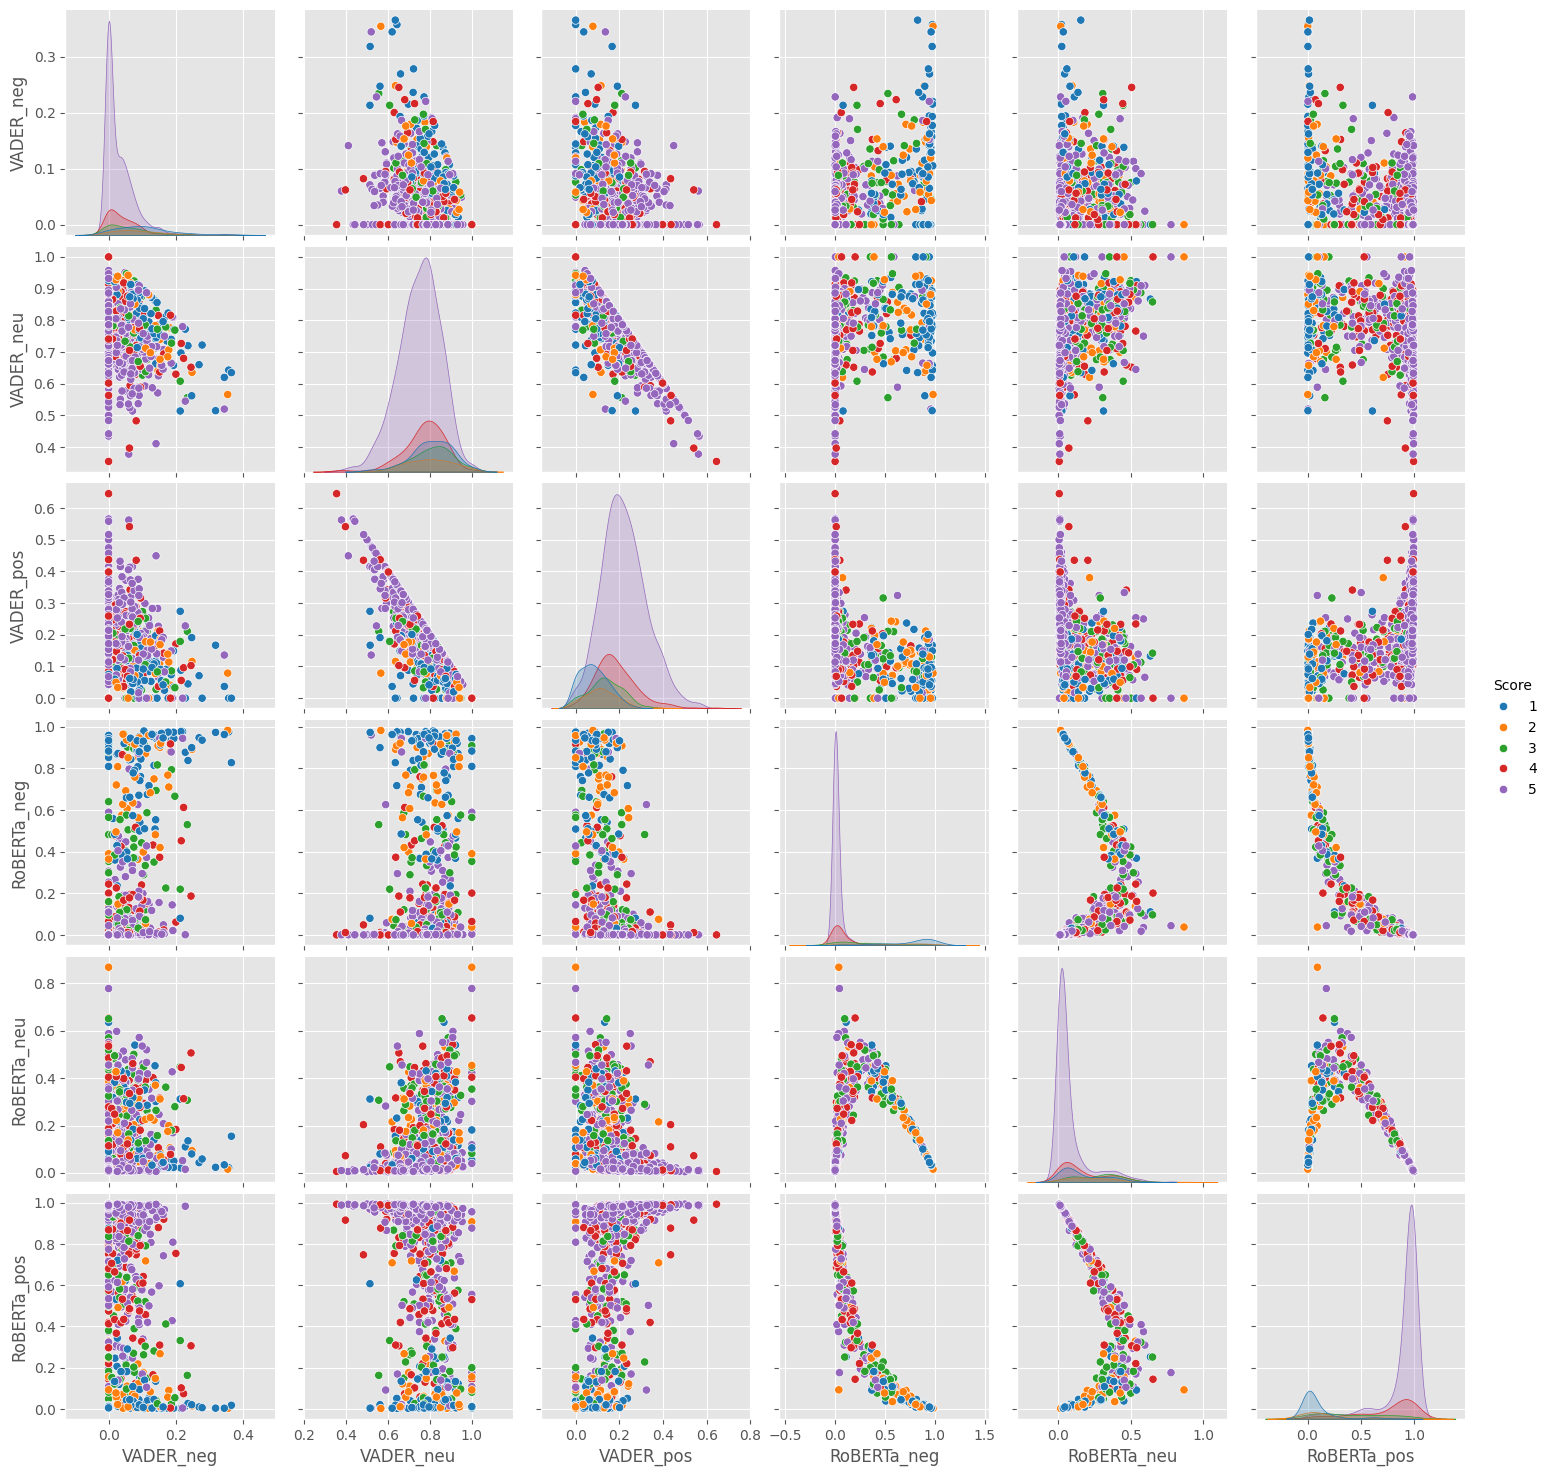

In [27]:
sns.pairplot(data=results_df,
             vars=['VADER_neg', 'VADER_neu', 'VADER_pos',
                   'RoBERTa_neg', 'RoBERTa_neu', 'RoBERTa_pos'],
             hue='Score',
             palette='tab10')

plt.show()

Looking at the plots above, we can see that RoBERTa model is more confident with predicting positive and negative scores compared to VADER. The distribution of the same pairs shows that RoBERTa's positive scores are much further to the right of the distribution than VADER's.

Looking at the purple datapoints which represent the 5 star reviews, we can see that whereas these span a wide range of positive VADER scores, they are more tightly packed to the high end of positive scores in the RoBERTa model. To a smaller degree this wide range scoring is also visible in the negative scores of VADER predictions whereas the RoBERTa model has clear confidence in its prediction of negative values.

This analysis shows the strengths of RoBERTa due to it's awareness of context and ability to use word embedding vectors that represent words in terms of their relationships and connections. Furthermore, being trained on a large corpus of text exposes RoBERTa to many more examples of the use of language teaching it intricacies and nuances that are missing from the VADER model.

RoBERTa is clearly the better option for sentiment analysis, particularly in more nuanced situations. It shows a grasp of being able to understand the language of Amazon reviews well, where sentiments and expression of feelings may not be clear cut.

## Step 4: Review Examples

Finally, we can review some examples where a model may have struggled or scored poorly. A good place to look is in 1 star reviews that were scored as having a positive sentiment and 5 star reviews were scored as having a negative sentiment. These may occur due to having a particular use of language that the models aren't used to or may be examples where the reviewer communicated their review in a way that doesn't align with what we expect of a very high or very low star rating.

In [28]:
print(results_df.query('Score == 1').sort_values('RoBERTa_pos', ascending=False)['Text'].values[0])

I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months.


Looking at this example, we can see this is clearly a serious and negative review hence the 1 star rating. There are a number of examples in the text that could have convinced the RoBERTa model that this is a positive review. Firstly, the use of many exclamation marks is often a sign of excitement or happiness. Furthermore, there is the capitalisation of the word loves which would suggest emphasis on the positivity of that part of the text. Furthermore, the second half of the model praises the product considerably. This is a clear example of where the nuance of text and language is still beyond the comprehension of NLP models, even an advanced model such as RoBERTa.

In [29]:
print(results_df.query('Score == 1').sort_values('VADER_pos', ascending=False)['Text'].values[0])

So we cancelled the order.  It was cancelled without any problem.  That is a positive note...


The customer in this case clearly wants to communicate a negative experience with the product. This can be seen in  both the sentiment of the message, a cancellation of the product and the low rating. They may be sarcastically claiming the ability to cancel with no problem was a positive note. VADER does not look at the relationship of words or the wider context in which they are used, so the model is likely to see the word positive and immediately believe there is a positive sentiment. Thus this message seems to demonstrate VADER's lack of context awareness from its bag of words approach to NLP.

In [30]:
print(results_df.query('Score == 5').sort_values('RoBERTa_neg', ascending=False)['Text'].values[0])

this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault


Here is an example where the message is generally negative in its sentiment although the star review rates the product highly. Although the customer states the product was delicious, they do show some negativity in saying they ate the item too fast and this resulted in a negative outcome for them. They also refer to the scenario being their own fault, suggesting a negative outcome and something RoBERTa is likely to predict as having a negative sentiment.

In [31]:
print(results_df.query('Score == 5').sort_values('VADER_neg', ascending=False)['Text'].values[0])

this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault


Looking at the 5 star review that VADER regarded as having the highest negative sentiment, we can see this is the same example that we saw with RoBERTa. As was discussed previously, this message is clearly communicating some negative sentiments although the rating is very high.

## Step 5: Conclusion

Overall, we can see that RoBERTa performs better than VADER in sentiment analysis thanks to its context awareness and ability to see the connection between words. The VADER bag of words approach is more suited to clear cut text examples where there is less nuance and intricacy to the use of language. This evaluation of the two models highlights the importance and bright future for transformer based models trained on a large corpus of text and the benefits of using pretrained models, especially when they can be modified and retrained to more specific use cases.